In [1]:
import os
from glob import glob
import tensorflow as tf
import pickle
import numpy as np
from ImageDataGenerator import ImageDataGenerator
import cv2
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
files_x = [file for file in glob("sample_dataset/image/*.jpg")]
files_test = [file for file in glob("sample_dataset/*.jpg")]
files_y_L = [file for file in glob("sample_dataset/mask/*_L.png")]
files_y_R = [file for file in glob("sample_dataset/mask/*_R.png")]

files_x.sort()
files_test.sort()
files_y_L.sort()
files_y_R.sort()

In [16]:
def crop_resize(img):
    img = img[200:, :]
    img = cv2.resize(img, (168, 44), interpolation=cv2.INTER_AREA)
    return img

def load_image(file):
    image = cv2.imread(file)
    image = crop_resize(image)
    return image

def load_mask(file):
    mask = mpimg.imread(file)
    mask = crop_resize(mask)
    return mask

def load_all_image_files(files): 
    images = [load_image(file) for file in files]
    images = np.stack(images)
    images = np.array(images)
    return images

def load_all_mask_files(files):
    masks = [load_mask(file) for file in files]
    masks = np.stack(masks)
    masks = masks[:, :, :, 3:4]
#     masks = np.array(masks)
    return masks

images = load_all_image_files(files_x)

masks_L = load_all_mask_files(files_y_L)
masks_R = load_all_mask_files(files_y_R)

masks = np.append(masks_L, masks_R, axis=3)

tests = load_all_image_files(files_test)

# only do 1 image for now
# images = images[0:1]
# masks = masks[0:1]

print(images.shape, masks.shape, tests.shape)

((9, 44, 168, 3), (9, 44, 168, 2), (27, 44, 168, 3))


(44, 168, 3)


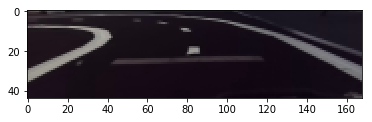

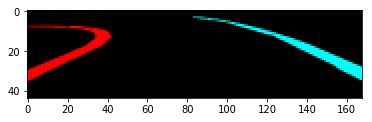

In [4]:
index = 1
plt.imshow(images[index])
plt.figure()
mask = masks[index]
mask = cv2.merge([mask[:,:,0], mask[:,:,1], mask[:,:,1]])
print(mask.shape)
plt.imshow(mask)

In [5]:
import threading
class BatchIndices(object):
    def __init__(self, n, batch_size, shuffle=False):
        self.n, self.batch_size, self.shuffle = n, batch_size, shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0
        
    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.batch_size, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [6]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [7]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([7, 8, 5]),
 array([9, 1, 4]),
 array([3, 2, 6]),
 array([0]),
 array([7, 1, 6])]

In [8]:
class segm_generator(object):
    def __init__(self, x, y, batch_size=64, train=True):
        self.x, self.y, self.batch_size, self.train = x, y, batch_size, train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, batch_size, train)

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)
    
    def get_item(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def get_item2(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def next(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys)

In [83]:
def overlay_mask(img, mask):
    overlay = np.copy(mask)
    overlay[overlay>=0.5] = 255
    overlay[overlay<0.5] = 0
    overlay = overlay.astype(np.uint8)
    overlay = cv2.merge((overlay[:,:,0], overlay[:,:,1], np.zeros_like(overlay[:,:,0])))
#     print(overlay.shape)
    combined = cv2.addWeighted(img, 1, overlay, 0.5, 0)
    return combined

def plot_images(img, mask):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    combined = overlay_mask(img, mask)
    plt.imshow(combined)

(44, 168, 3)


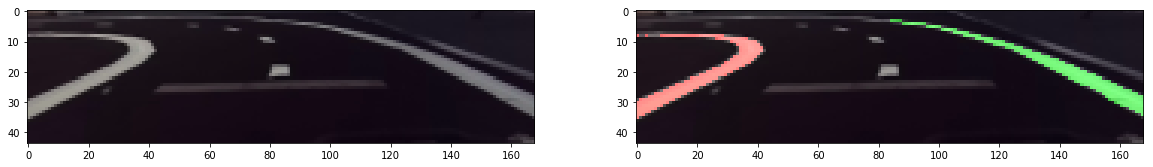

In [78]:
gen = segm_generator(images, masks, batch_size=11, train=False)
x, y = next(gen)

plot_images(x[1], y[1])


https://github.com/0bserver07/One-Hundred-Layers-Tiramisu/blob/master/model-tiramasu-56.py

In [ ]:
# import keras.models as models
from keras.models import Model
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers import Input, Conv2D, Conv2DTranspose

from keras import backend as K

import cv2
import numpy as np
import json

# weight_decay = 0.0001
from keras.regularizers import l2


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = y_pred + threshold_shift

    tp = K.sum(y_true * y_pred_bin) + K.epsilon()
    fp = K.sum(K.clip(y_pred_bin - y_true, 0, 1))
    fn = K.sum(K.clip(y_true - y_pred, 0, 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def fbeta_loss(y_true, y_pred):
    return -fbeta(y_true, y_pred)

class Tiramisu():
    def __init__(self, load=False):
        if load:
            self.load()
        else:
            self.create()
        
    def DenseBlock(self, x, nb_layers, filters, name="dense_block"):
        layers = [x]
        for i in range(nb_layers):
            x = BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001))(x)
            x = Activation('relu')(x)
            x = Conv2D(filters, kernel_size=(3, 3), padding='same', 
                       name=name+"_conv_layer_"+str(i), kernel_initializer="he_uniform")(x)
            x = Dropout(0.2)(x)
            layers.append(x)
            x = Concatenate(name=name+"_concatenate_"+str(i))(layers)
#             filters += growth_rate
        return x

    def TransitionDown(self, x, filters, name="transition_down"):
        x = BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001))(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size=(1, 1), padding='same', 
                   name=name+"_conv", kernel_initializer="he_uniform")(x)
        x = Dropout(0.2)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name=name+"_pool")(x)
        return x

    def TransitionUp(self, x, filters, skip_connection, name="transition_up"):
        x = Conv2DTranspose(100,  kernel_size=(3, 3), strides=(2, 2), padding='same', 
                            name=name+"_conv", kernel_initializer="he_uniform")(x)
        x = Concatenate(name=name+"_concatenate")([x, skip_connection])
        return x


    def create(self):
        model_input = Input(shape=(44,168,3))
        first_layer = Conv2D(12, kernel_size=(3, 3), padding='same',
                            kernel_initializer="he_uniform", activation="relu",
                            kernel_regularizer = l2(0.0001), name="first_layer")(model_input)

        nb_layers = 2
        nb_filters = 12
        growth_rate = 12
        # total_filters = input + nb_layers*nb_filters
        
        filters_1 = 12 + nb_layers * nb_filters  # 12 + 2 * 12 = 36
        block_1 = self.DenseBlock(first_layer, nb_layers, nb_filters, name="block1")
        down = self.TransitionDown(block_1, filters_1, name="block1_TD")

        filters_2 = filters_1 + nb_layers * nb_filters # 36 + 2 * 12 = 60
        block_2 = self.DenseBlock(down, nb_layers, nb_filters, name="block2")
        down = self.TransitionDown(block_2, filters_2, name="block2_TD")
        
        filters_3 = filters_2 + nb_layers * nb_filters # 60 + 2 * 12 = 84
        block_3 = self.DenseBlock(down, nb_layers, nb_filters, name="block3")
#         down = self.TransitionDown(block_3, filters_3, name="block3_TD")
        
#         filters_4 = filters_3 + nb_layers * nb_filters # 84 + 2 * 12 = 108   
#         block_4 = self.DenseBlock(down, nb_layers, nb_filters, name="block4")
        
        up = self.TransitionUp(block_3, filters_3, block_2, name="TU") # 108 + 84  = 192
        
#         filters_up_1 = filters_4 + filters_3 + nb_layers * nb_filters # 192 + 2 * 12 = 216
#         block_3 = self.DenseBlock(up, nb_layers, nb_filters, name="block3_up")  
#         up = self.TransitionUp(block_3, filters_up_1, block_2, name="block3_TU")
        
        filters_up_2 = filters_3 + filters_2 + nb_layers * nb_filters # 216 + 60 + 2 * 12  = 300
        block_2 = self.DenseBlock(up, nb_layers, nb_filters, name="block2_up")
        up = self.TransitionUp(block_2, filters_up_2, block_1, name="block2_TU")
        
        filters_up_1 = filters_up_2 + filters_1 + nb_layers * nb_filters # 300 + 36 + 2 * 12 = 360
        block_1 = self.DenseBlock(up, nb_layers, nb_filters, name="block1_up")
        
        
        last_layer = Conv2D(2, kernel_size=(1, 1), padding='same',
                            kernel_initializer="he_uniform",
                            kernel_regularizer = l2(0.0001), name="last_layer")(block_1)
        out = Activation('sigmoid')(last_layer)
        
        self.model = Model(inputs=[model_input], outputs=[out])
        self.model.summary()

#         with open('tiramisu_fc_dense56_model.json', 'w') as outfile:
#             outfile.write(json.dumps(json.loads(model.to_json()), indent=3))

    def save(self):
#         self.model.save("tiramisu_model.h5", overwrite=True)
        self.model.save_weights("tiramisu_weights.h5", overwrite=True)
        
    def load(self):
        self.create()
        self.model.load_weights("tiramisu_weights.h5")
        
    def predict(self, images):
        return self.model.predict(images)

    def predict_one(self, image):
        return self.model.predict(np.expand_dims(image, axis=0))[0]

tiramisu = Tiramisu(load=False)
tiramisu.model.compile(loss=dice_coef_loss, 
              optimizer=keras.optimizers.Adam(1e-3), metrics=[fbeta])

In [ ]:
tiramisu.model.optimizer=keras.optimizers.Adam(1e-3)
history = tiramisu.model.fit_generator(gen, steps_per_epoch=20, epochs=20, verbose=2)

In [ ]:
test = x[1:2]
print(test.shape)

%time test_label = tiramisu.model.predict(test)
print(test_label.shape)
plot_images(test[0], test_label[0])

# plt.figure()
# plt.imshow(test_label[0][:,:,1])

out = np.squeeze(test_label[0])
# plt.imshow(out)
# print(out)

In [166]:
# import keras.models as models
from keras.models import Model
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers import Input, Conv2D, Conv2DTranspose

from keras import backend as K

import cv2
import numpy as np
import json

from keras.regularizers import l2


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = y_pred + threshold_shift

    tp = K.sum(y_true * y_pred_bin) + K.epsilon()
    fp = K.sum(K.clip(y_pred_bin - y_true, 0, 1))
    fn = K.sum(K.clip(y_true - y_pred, 0, 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def fbeta_loss(y_true, y_pred):
    return -fbeta(y_true, y_pred)

class DilatedSegmentater():
    def __init__(self, load=False):
        if load:
            self.load()
        else:
            self.create()
        
    def create(self):
        model_input = Input(shape=(44,168,3))
        layer = Conv2D(12, kernel_size=(3, 3), padding='same', dilation_rate=(1,1),
                            kernel_initializer="he_uniform", activation="relu",
                            kernel_regularizer = l2(0.0001), name="layer_1")(model_input)
        
        layer = Conv2D(24, kernel_size=(3, 3), padding='same', dilation_rate=(2,2),
                            kernel_initializer="he_uniform", activation="relu",
                            kernel_regularizer = l2(0.0001), name="layer_2")(layer)
        
#         layer = Conv2D(24, kernel_size=(3, 3), padding='same', dilation_rate=(1,1),
#                             kernel_initializer="he_uniform", activation="relu",
#                             kernel_regularizer = l2(0.0001), name="layer_3")(layer)
        
        layer = Conv2D(36, kernel_size=(3, 3), padding='same', dilation_rate=(2,2),
                            kernel_initializer="he_uniform", activation="relu",
                            kernel_regularizer = l2(0.0001), name="layer_4")(layer)

#         layer = Conv2D(36, kernel_size=(3, 3), padding='same', dilation_rate=(1,1),
#                             kernel_initializer="he_uniform", activation="relu",
#                             kernel_regularizer = l2(0.0001), name="layer_5")(layer)
        
        layer = Conv2D(48, kernel_size=(3, 3), padding='same', dilation_rate=(2,2),
                            kernel_initializer="he_uniform", activation="relu",
                            kernel_regularizer = l2(0.0001), name="layer_6")(layer)
        
        out = Conv2D(2, kernel_size=(3, 3), padding='same',
                            kernel_initializer="he_uniform", activation="sigmoid",
                            kernel_regularizer = l2(0.0001), name="last_layer")(layer)
#         out = Activation('sigmoid')(last_layer)
        
        self.model = Model(inputs=[model_input], outputs=[out])
        self.model.summary()

#         with open('tiramisu_fc_dense56_model.json', 'w') as outfile:
#             outfile.write(json.dumps(json.loads(model.to_json()), indent=3))

#     def save(self):
# #         self.model.save("tiramisu_model.h5", overwrite=True)
#         self.model.save_weights("tiramisu_weights.h5", overwrite=True)
        
#     def load(self):
#         self.create()
#         self.model.load_weights("tiramisu_weights.h5")
        
    def predict(self, images):
        return self.model.predict(images)

    def predict_one(self, image):
        return self.model.predict(np.expand_dims(image, axis=0))[0]

dilated_segmenter = DilatedSegmentater(load=False)
dilated_segmenter.model.compile(loss=dice_coef_loss, 
              optimizer=keras.optimizers.Adam(1e-3), metrics=[fbeta])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 44, 168, 3)        0         
_________________________________________________________________
layer_1 (Conv2D)             (None, 44, 168, 12)       336       
_________________________________________________________________
layer_2 (Conv2D)             (None, 44, 168, 24)       2616      
_________________________________________________________________
layer_4 (Conv2D)             (None, 44, 168, 36)       7812      
_________________________________________________________________
layer_6 (Conv2D)             (None, 44, 168, 48)       15600     
_________________________________________________________________
last_layer (Conv2D)          (None, 44, 168, 2)        866       
Total params: 27,230
Trainable params: 27,230
Non-trainable params: 0
_________________________________________________________________


In [167]:
dilated_segmenter.model.optimizer=keras.optimizers.Adam(1e-3)
history = dilated_segmenter.model.fit_generator(gen, steps_per_epoch=80, epochs=5, verbose=2)

Epoch 1/5
1s - loss: -7.0308e-01 - fbeta: 0.7387
Epoch 2/5
1s - loss: -8.7877e-01 - fbeta: 0.8997
Epoch 3/5
1s - loss: -8.8647e-01 - fbeta: 0.9047
Epoch 4/5
1s - loss: -8.9555e-01 - fbeta: 0.9116
Epoch 5/5
1s - loss: -8.9651e-01 - fbeta: 0.9117


(27, 44, 168, 3)
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 163 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.26 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.48 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.47 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.45 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.27 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.29 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.48 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.39 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.58 ms


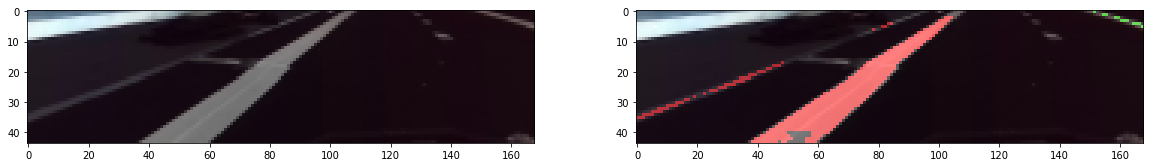

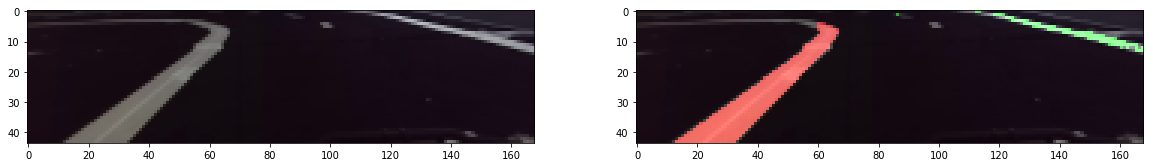

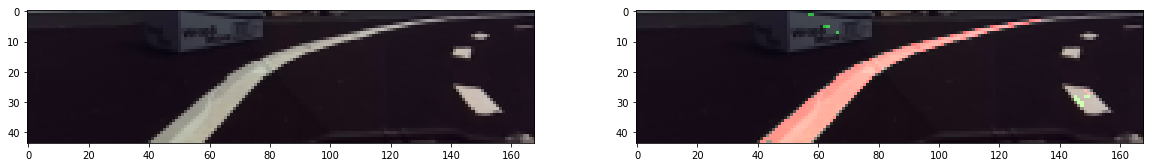

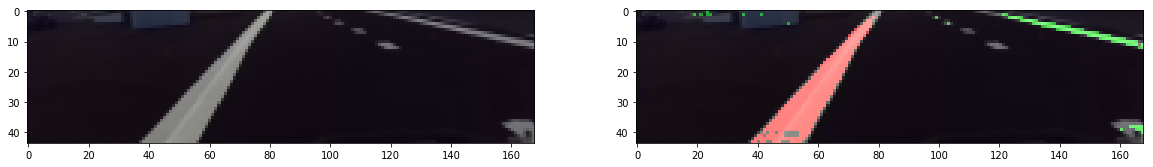

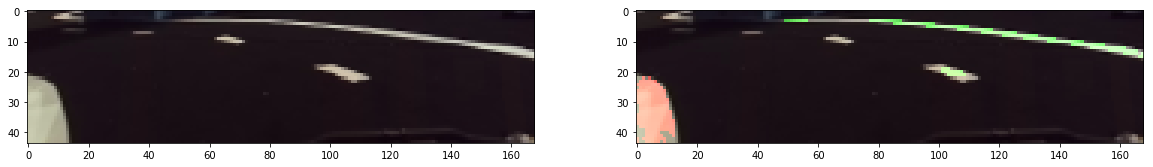

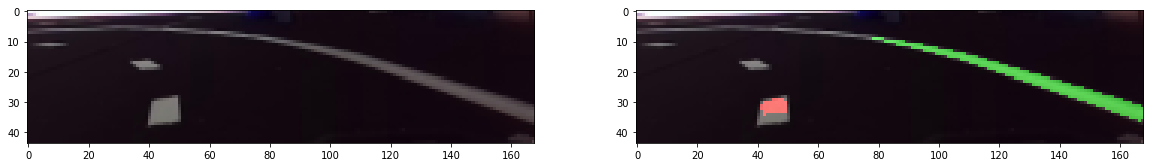

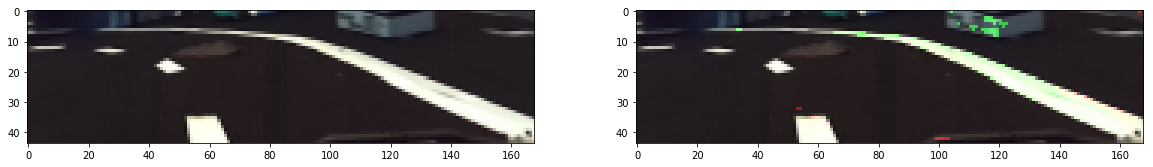

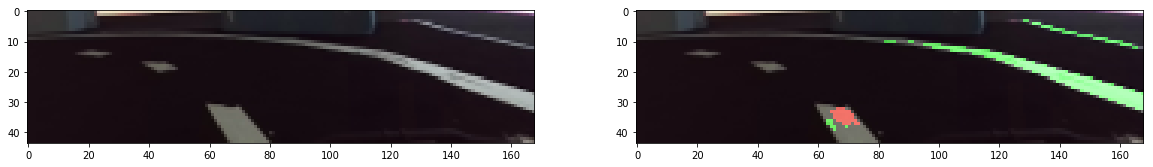

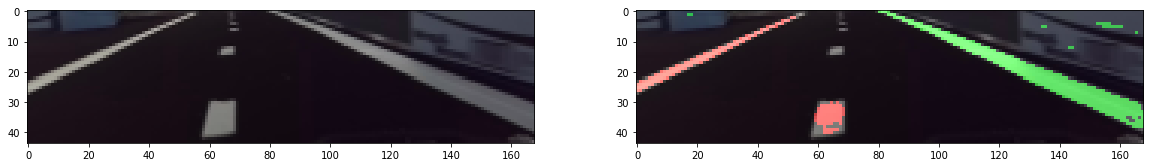

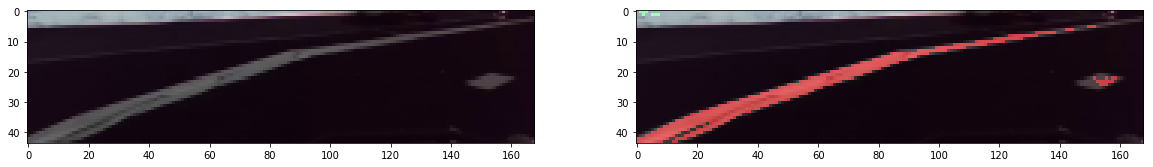

In [119]:
index=np.random.randint(tests.shape[0])
index=5
test = tests
# test = images
print(test.shape)

for i in range(10):
    %time test_label = dilated_segmenter.predict_one(test[i])
    plot_images(test[i], test_label)

out = np.squeeze(test_label[0])
# plt.imshow(out)
# print(out)

In [ ]:
from moviepy.editor import ImageSequenceClip



In [ ]:

def to_clip(images, filename="movie.mp4"):
    images_out = []
    for i in range(images.shape[0]):
        images_out.append(images[i])
    clip = ImageSequenceClip(images_out, fps=30)
    clip.write_videofile(filename,fps=30)
    
to_clip(tests)

In [ ]:
files_race1 = [file for file in glob("race1/*.jpg")]

images_race1 = load_all_image_files(files_race1)

print(images_race1.shape)

In [ ]:
images_race1_test = images_race1[0:200]
print(images_race1_test.shape)

In [ ]:
images_race1_predictions=[]
for idx, img in enumerate(images_race1):
    img = np.expand_dims(img, axis=0)
    output = tiramisu.model.predict(img)
    output = overlay_mask(img[0], output[0])
    images_race1_predictions.append(output)
images_race1_predictions = np.stack(images_race1_predictions)

# %time predictions = tiramisu.model.predict(images_race1_test)

# print(predictions.shape)
to_clip(images_race1_predictions)

In [ ]:
index=np.random.randint(tests.shape[0])
index = 15
test = tests[index:index+1]
print(test.shape)

# %time test_label = tiramisu.model.predict(test)
%time prediction = tiramisu.predict_one(test[0])
# print(test_label)
# plot_images(test[0], test_label[0])
plot_images(test[0], prediction)

prediction[prediction >= 0.9] = 1
prediction[prediction <= 0.9] = 0

In [ ]:
index=np.random.randint(tests.shape[0])
test = tests[index:index+1]
# test = images.copy()

%time prediction = tiramisu.predict_one(test[0])

from scipy.ndimage.measurements import label
# left = minus, right = plus
def get_steering_from_prediction(prediction, original=None):
    prediction[prediction >= 0.9] = 1
    prediction[prediction <= 0.9] = 0
    labels = label(prediction[:,:,0])
    positive_gradients = [] 
    negative_gradients = []
    
    img = None
    if original is not None:
        img = original.copy()

    for object_no in range(1, labels[1]+1):
        # Find pixels with each  label value
        nonzero = (labels[0] == object_no).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if ((np.max(nonzeroy)-np.min(nonzeroy)>10) & (np.max(nonzerox)-np.min(nonzerox)>10)):
            fit = np.polyfit(nonzeroy, nonzerox, 1)
            # gradients are reversed because the image starts with 0 at the top
            if(fit[0] > 0):
                negative_gradients.append(-fit[0])
            else:
                positive_gradients.append(-fit[0])
            if original is not None:
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 1)
    
    # add small value to avoid nan
    if len(positive_gradients) == 0:
        positive_gradients.append(1e-3)
    if len(negative_gradients) == 0:
        negative_gradients.append(1e-3)

    if original is not None:
        print(positive_gradients, negative_gradients)
        print(np.mean(positive_gradients), np.mean(negative_gradients))
        figure = plt.figure(figsize=(20,12))
        plt.imshow(img, cmap='gray')
    return np.mean(positive_gradients) + np.mean(negative_gradients)

%time steering = get_steering_from_prediction(prediction)
print(steering)

In [ ]:
def plot_two(img1, img2):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)